In [2]:
from google.colab import drive
import sys
import os
mount='/content/drive'
drive.mount(mount)
drive_root = mount + "/My Drive/colab/pytorch-lasso-master"
%cd $drive_root

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/colab/pytorch-lasso-master


In [30]:
ls lasso/linear

dict_learning.py  k_deep_simplex.py  solvers/          utils.py
__init__.py       __pycache__/       sparse_encode.py


In [31]:
import math
import time
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, Colormap
import torch
import numpy as np

from lasso.linear import dict_learning, dict_evaluate, k_deep_simplex, sparse_encode
import torch.nn.functional as F
from torch.nn.modules.utils import _pair
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
import torchvision

# Data

Load the Omniglot dataset (using torchvision) and extract patches

In [5]:
# extra transfrom for the training data, in order to achieve better performance
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Grayscale(), 
])

dataset = CIFAR10(root="/data/", download=True, transform=train_transform)

Files already downloaded and verified


In [6]:
images = torch.stack([dataset[i][0] for i in range(len(dataset))])
image_labels = [dataset[i][1] for i in range(len(dataset))]
images.shape

torch.Size([50000, 1, 32, 32])

In [6]:
def extract_patches2d(x, kernel_size=17, stride=7, padding=0):
    kernel_size = _pair(kernel_size)
    stride = _pair(stride)
    padding = _pair(padding)
    if padding != (0,0):
        x = F.pad(x, [padding[1], padding[1], padding[0], padding[0]])
    x = x.unfold(2, kernel_size[0], stride[0]).unfold(3, kernel_size[1], stride[1])
    x = x.permute(2,3,0,1,4,5).reshape(-1, *kernel_size)
    return x

def sample_patches(images, ntrain, ntest, **kwargs):
    # extract image patches
    patches = extract_patches2d(images, **kwargs)
    
    # remove empty patches
    patches = patches[patches.sum([1,2]) > 0]
    
    # select train/test examples
    assert images.size(0) >= ntrain + ntest, 'not enough data for the desired ntrain/ntest'
    idx = torch.randperm(patches.size(0))
    
    return patches[idx[:ntrain]], patches[idx[ntrain:ntrain+ntest]]

In [54]:
torch.manual_seed(924)
#X_train, X_test = sample_patches(images, ntrain=25000, ntest=5000)
X_train_raw, X_test_raw = images[:40000].squeeze(), images[40000:].squeeze()
y_train, y_test = np.array(image_labels[:40000]), np.array(image_labels[40000:])
print(y_train.shape)
print(y_test.shape)

(40000,)
(10000,)


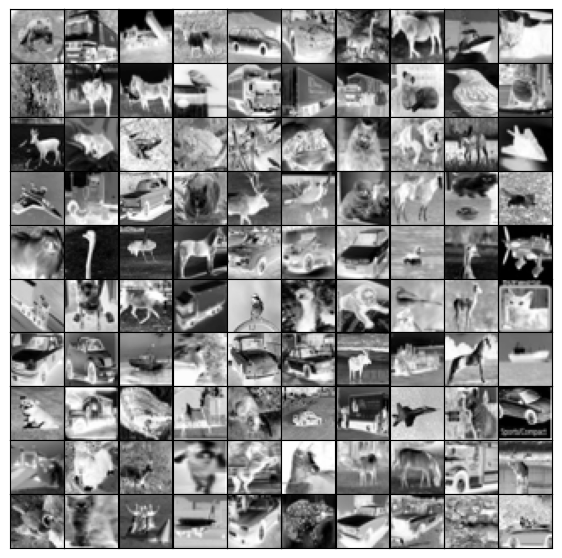

In [8]:
torch.manual_seed(399)
fig, axes = plt.subplots(10, 10, figsize=(7,7))
axes = axes.ravel()
for i in range(100):
    axes[i].imshow(X_train[i], cmap=plt.cm.binary)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

In [55]:
# flatten patches to vectors
X_train_flat = X_train_raw.flatten(1)
X_test_flat = X_test_raw.flatten(1)

# z-score the data
xmean = X_train_flat.mean()
xstd = X_train_flat.std()
X_train = (X_train_flat - xmean) / xstd
X_test = (X_test_flat - xmean) / xstd

print(X_train.shape)
print(X_test.shape)

torch.Size([40000, 1024])
torch.Size([10000, 1024])


# Utility code

these functions will be used for plotting, etc.

# Experiments

We will compare two different dictionary learning settings:
1. constrained dictionary. The basis vectors are constrained to have unit norm
2. unconstrained dictionary. The basis vectors are unconstrained, but we place an L2 penalty on them

The `Iterated Ridge` method is memory-hungry in the default "Cholesky Factorization" mode (my GPU runs out of memory with the full dataset). Thus, we try two versions of this algorithm: 1) a version that uses the full dataset, but an approximate CG-based solver, and 2) a version with the default Cholesky solver, but only a subset of the data.

In [10]:
#device = torch.device('cuda')
device = torch.device('cuda')  # use this if no GPU available

# Constrained dictionary learning

ISTA

In [11]:
torch.manual_seed(32)
num_atoms = 144
lam = 0.4
options = dict(algorithm='ista', init='ridge', maxiter=100, fast=True, lr='auto')
weight, losses, Z = dict_learning(X_train, num_atoms, alpha=lam, constrained=True, device=device, steps=250, **options)
time.sleep(0.3)
print('test loss: %0.4f' % dict_evaluate(X_test, weight, alpha=lam, **options))

100%|██████████| 250/250 [02:34<00:00,  1.61it/s, loss=82.6]


test loss: 82.4624


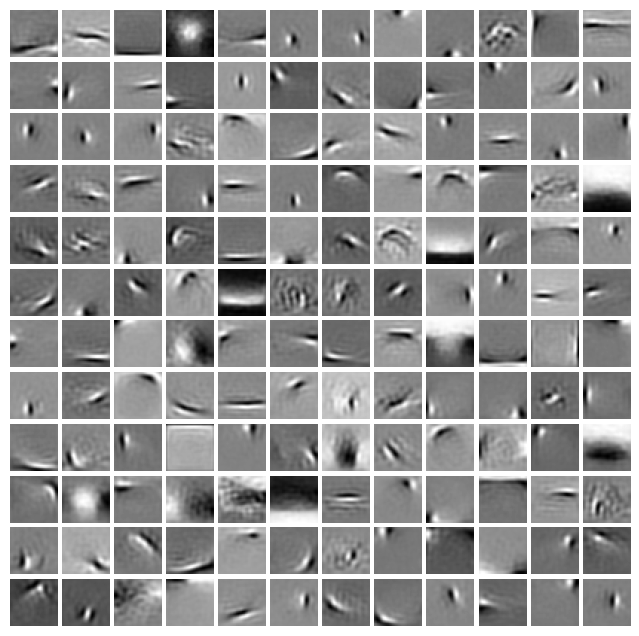

In [69]:
weight_np = weight.cpu().numpy()
fig = plt.figure(figsize=(8, 8))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
for i in range(num_atoms):
    plt.subplot(12, 12, i+1)
    plt.imshow(np.reshape(weight_np[:,i], (32, 32)), cmap="gray")
    plt.axis("off")

#plt.savefig('vanilla_sparse_coding_filters_cifar10.png')

In [13]:
sc_Z = Z.cpu().numpy()
sc_Z.shape

(40000, 144)

In [14]:
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
embedding = Isomap(n_neighbors=16, n_components=10)
X_transformed = embedding.fit_transform(sc_Z[:2000])

In [68]:
visualization_embedding = TSNE(n_components=2)
X_transformed_viz_sc = visualization_embedding.fit_transform(sc_Z)

fig = plt.gcf()
plt.rcParams.update({'font.size': 13, 'font.family': 'serif'})
plt.scatter(X_transformed_viz_sc[:,0], X_transformed_viz_sc[:,1], c=y_train, alpha=0.7, cmap='plasma', s=10)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(linestyle="dotted", linewidth=0.5)
fig.set_dpi(1000)
fig.savefig('vanilla_sparse_coding_tsne_projection_cifar10.png', dpi=1000)

Output hidden; open in https://colab.research.google.com to view.

In [17]:
from sklearn.cluster import KMeans
import sklearn
sc_Z_test = sparse_encode(x=X_test.to(device), weight=weight, alpha=0.4, z0=None)
X_transformed_test = embedding.fit_transform(sc_Z_test.cpu().numpy()[:1000])
kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto").fit(X_transformed_test)
contingency = sklearn.metrics.cluster.contingency_matrix(labels_true=y_test[:1000], labels_pred=kmeans.labels_)

In [20]:
print(np.sum(np.max(contingency, axis=1)) / 1000)
#plt.scatter(X_transformed_test[:,0], X_transformed_test[:,1], c=y_test)

0.256


In [22]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X_transformed, y_train[:2000])
score = neigh.score(X_transformed_test, y_test[:1000])
print(score)

0.123


KDS code

In [61]:
num_layers = 15 
kds_lr = 1e-2
kds_epochs = 100
penalty = 0.01
num_atoms = 144
batch_size = 256
X_train_norm = X_train_flat / np.linalg.norm(X_train_flat, axis=1, keepdims=True) 
net = k_deep_simplex.KDS(num_layers=num_layers, input_size=32**2, penalty=penalty, hidden_size=num_atoms, train_step=True)
loss, dic, codes = k_deep_simplex.run_kds_experiment(lam=penalty, data=X_train_norm, net=net, lr=kds_lr, epochs=kds_epochs, batch_size=batch_size, device=device)

100%|██████████| 100/100 [04:38<00:00,  2.79s/it]


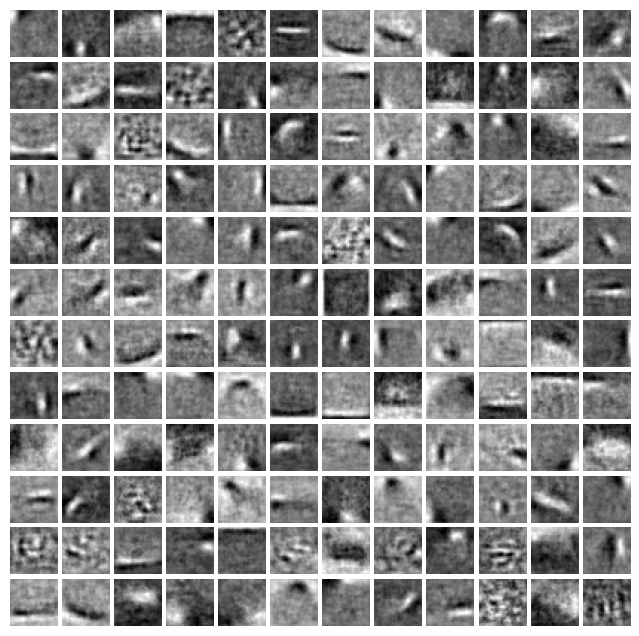

In [70]:
fig = plt.figure(figsize=(8, 8))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
for i in range(num_atoms):
    plt.subplot(12, 12, i+1)
    plt.imshow(np.reshape(dic.T[:,i], (32, 32)), cmap="gray")
    plt.axis("off")

#plt.savefig('kds_filters_cifar10.png')

In [71]:
visualization_embedding = TSNE(n_components=2)
X_transformed_viz_sc = visualization_embedding.fit_transform(codes)

fig = plt.gcf()
plt.rcParams.update({'font.size': 13, 'font.family': 'serif'})
plt.scatter(X_transformed_viz_sc[:,0], X_transformed_viz_sc[:,1], c=y_train, alpha=0.7, cmap='plasma', s=10)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(linestyle="dotted", linewidth=0.5)
fig.set_dpi(1000)
fig.savefig('kds_tsne_projection_cifar10.png', dpi=1000)

Output hidden; open in https://colab.research.google.com to view.

In [65]:
X_transformed_test_kds = embedding.fit_transform(codes[:1000])
kmeans_kds = KMeans(n_clusters=10, random_state=0, n_init="auto").fit(X_transformed_test_kds)
contingency = sklearn.metrics.cluster.contingency_matrix(labels_true=y_test[:1000], labels_pred=kmeans_kds.labels_)
print(np.sum(np.max(contingency, axis=1)) / 1000)

0.287
